In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
%matplotlib inline
from itertools import combinations
from itertools import chain
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools
from tools import mutant_colorset
from tools import condition_colorset

In [2]:
np.random.seed(953527608) # for exact figure reproducibility use this seed
# np.random.seed(None)

In [3]:
cov_thresh = 1e6
fitness_data = p.read_csv('../data/fitnesses_merged_NoWeight_resample1000000.csv')

In [4]:
mutant_train_set = p.read_csv('../data/mutant_train_set.csv')
training_bcs = mutant_train_set['barcode'].values

In [5]:
old_conditions = {
                  '3':['3.1','3.2','3.3'],
                  '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3']
                 }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
#                         '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.2MKCl' :['O'],
#                         '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
                      }


# m3_conditions = {**old_conditions,}
conditions = {**old_conditions, **bigbatch_conditions}
all_conditions = conditions.keys()
all_reps = [rep for reps in conditions.values() for rep in reps]

m3_conditions = list(old_conditions.keys()) + ['1BB_M3']
m3_reps = [rep for condition in m3_conditions for rep in conditions[condition]]


In [35]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

fitness_cols = [col for col in this_data.columns if '_fitness' in col]

fitness = this_data[fitness_cols].values

# converting instead to correlation matrix!!!
fitness = (fitness - np.mean(fitness,axis=0))/np.std(fitness,axis=0)

# use only rank
fitness = np.asarray([scipy.stats.rankdata(fitness[:,i]) for i in range(fitness.shape[1])]).swapaxes(0,1)



n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]



In [34]:
np.asarray(fitness).shape

(8823, 224)

In [36]:
nonM3_1bb_conditions =       {
#                         '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
                        '1BB_0.2MNaCl' :['K','L'],
                        '1BB_0.2MKCl' :['O'],
                        '1BB_0.5MKCl' :['P'],
                        '1BB_8.5uMGdA' :['Q','R'],
                        '1BB_17uMGdA' :['S','T'],
                        '1BB_2ugFlu' :['U','V'],
                        '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD']}
nonM3_1bb_reps = [rep for reps in nonM3_1bb_conditions.values() for rep in reps]

test_conditions =       {
#                         '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
#                         '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.2MKCl' :['O'],
#                         '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD']}
test_reps = [rep for reps in test_conditions.values() for rep in reps]
test_conditions = [rep+'_original_fitness' for reps in test_conditions.values() for rep in reps]


test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]


In [37]:
test_reps

['E', 'F', 'G', 'H', 'I', 'J', 'Y', 'Z', 'AA', 'BB', 'CC', 'DD']

In [38]:
resample_names = np.unique([col.split('_resample')[0] for col in fitness_cols if 'resample' in col and col[0] not in nonM3_1bb_reps])

resample_predictions = {}

for train_set in resample_names:
    train_conditions = [col for col in fitness_cols if col.split('_resample')[0] == train_set]
    train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]
    
    all_locs = sorted(list(train_locs)+list(test_locs))
    
    this_fitness = fitness[:,all_locs]
    new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
    new_test_locs = np.where(np.isin(all_locs,test_locs))[0]
    
    train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
    test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]

    by_rank, by_condition, by_mutant, mean_fits = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=False,by_mutant=False)

    resample_predictions[train_set] = [max(by_rank),np.where(by_rank==max(by_rank))[0][0]]

In [39]:
resample_predictions

{'13.1': [0.5671793116582659, 1],
 '13.1_T1to2': [0.5877337986025168, 1],
 '13.1_T2to3': [0.5565714410591911, 3],
 '13.1_T3to4': [0.44592020375175223, 0],
 '13.2': [0.5738691412718036, 0],
 '13.2_T1to2': [0.5701595097003538, 0],
 '13.2_T2to3': [0.6070567376742051, 0],
 '13.2_T3to4': [0.445419162737978, 8],
 '13.3': [0.4740348471370919, 3],
 '13.3_T3to4': [0.12737843522606784, 1],
 '18.1': [0.5224239250315232, 1],
 '18.1_T3to4': [0.5150739336405846, 0],
 '18.3': [0.5900712646878519, 0],
 '18.3_T2to3': [0.5065551851474105, 1],
 '18.3_T3to4': [0.5466952027773728, 0],
 '20.1': [0.38379884587267543, 0],
 '20.1_T2to3': [0.38755480053963665, 1],
 '20.2': [0.5633968844901225, 0],
 '20.2_T1to2': [0.28302773532027026, 0],
 '20.2_T2to3': [0.46641191091734313, 1],
 '20.2_T3to4': [0.2988128444873742, 2],
 '20.3': [0.604202295616519, 3],
 '20.3_T1to2': [0.3138920789342313, 6],
 '20.3_T2to3': [-0.1490222312766174, 2],
 '20.3_T3to4': [0.4009759791875236, 0],
 '21.1': [0.34767537073857324, 1],
 '21.1_T

In [40]:
tech_cols = [col for col in fitness_cols if 'DE' in col and 'resample' in col]

tech_single_t_train_sets = {}
for rep in ['A','B','C','D']:
    for t in range(4):
        this_rep_t = [col for col in tech_cols if f'{rep}.' in col and f'.{t}-' in col]
        if len(this_rep_t) > 1:
            tech_single_t_train_sets[f'{rep}_{t}'] = this_rep_t

technical_predictions = {}

for train_set in tech_single_t_train_sets:
    train_conditions = tech_single_t_train_sets[train_set]
    train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]
    
    all_locs = sorted(list(train_locs)+list(test_locs))
    
    this_fitness = fitness[:,all_locs]
    new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
    new_test_locs = np.where(np.isin(all_locs,test_locs))[0]
    
    train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
    test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]

    by_rank, by_condition, by_mutant, mean_fits = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=False,by_mutant=False)

    technical_predictions[train_set] = [max(by_rank),np.where(by_rank==max(by_rank))[0][0]]

In [41]:

rep_train_sets = {}

for rep in m3_reps:
    candidates = [col for col in fitness_cols if rep == col.split('_')[0] and 'resample' in col and len(col.split('_'))==5]
    if len(candidates) > 0:
        rep_train_sets[rep] = candidates

rep_predictions = {}

for train_set in rep_train_sets:
    train_conditions = rep_train_sets[train_set]
    train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]
    
    all_locs = sorted(list(train_locs)+list(test_locs))
    
    this_fitness = fitness[:,all_locs]
    new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
    new_test_locs = np.where(np.isin(all_locs,test_locs))[0]
    
    train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
    test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]

    by_rank, by_condition, by_mutant, mean_fits = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=False,by_mutant=False)

    rep_predictions[train_set] = [max(by_rank),np.where(by_rank==max(by_rank))[0][0]]

In [42]:

batch_train_sets = {}

for condition in m3_conditions:
    candidates = []
    for rep in conditions[condition]:
        candidates = candidates + [col for col in fitness_cols if rep == col.split('_')[0] and 'resample' in col and len(col.split('_'))==5]
    if len(candidates) > 0:
        batch_train_sets[condition] = candidates

batch_predictions = {}

for train_set in batch_train_sets:
    train_conditions = batch_train_sets[train_set]
    train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]
    
    all_locs = sorted(list(train_locs)+list(test_locs))
    
    this_fitness = fitness[:,all_locs]
    new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
    new_test_locs = np.where(np.isin(all_locs,test_locs))[0]
    
    train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
    test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]

    by_rank, by_condition, by_mutant, mean_fits = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=False,by_mutant=False)

    batch_predictions[train_set] = [max(by_rank),np.where(by_rank==max(by_rank))[0][0]]

In [43]:
# resample_names = np.unique([col.split('_resample')[0] for col in fitness_cols if 'resample' in col if col[0] not in test_reps])
# resample_names = [col for col in fitness_cols if 'resample' in col if col[0] not in test_reps]

all_predictions = {}

train_conditions = [col for col in fitness_cols if 'resample' in col and col[0] not in nonM3_1bb_reps]
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

all_locs = sorted(list(train_locs)+list(test_locs))
    
this_fitness = fitness[:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]

train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]

by_rank, by_condition, by_mutant, mean_fits = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=False,by_mutant=False)

all_predictions['all'] = [max(by_rank),np.where(by_rank==max(by_rank))[0][0]]

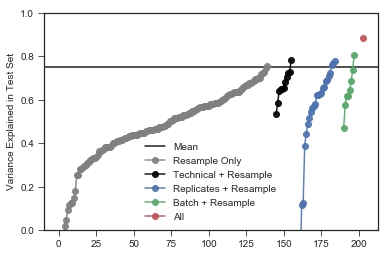

In [44]:
train_names = ['Resample Only','Technical + Resample','Replicates + Resample','Batch + Resample','All']
train_colors = ['gray','black','b','g','r']
predictions = [list(sorted(np.asarray(list(resample_predictions.values()))[:,0])),
               list(sorted(np.asarray(list(technical_predictions.values()))[:,0])),
               list(sorted(np.asarray(list(rep_predictions.values()))[:,0])),
               list(sorted(np.asarray(list(batch_predictions.values()))[:,0])),
              list(sorted(np.asarray(list(all_predictions.values()))[:,0]))]

running_index = 0
plt.axhline(mean_fits,color='k',label='Mean')
for p,p_set in enumerate(predictions):
    
    plt.plot(range(running_index,running_index+len(p_set)),p_set,'o-',color=train_colors[p],alpha=0.9,label=train_names[p])
#     if p+1 == len(predictions):
#         plt.plot(range(running_index,running_index+len(p_set)),p_set,'o-',color='r')
#     else:
#         plt.plot(range(running_index,running_index+len(p_set)),p_set,'o-',color='b')
#         plt.axvline(running_index,linestyle='--',color='gray')
    running_index += len(p_set) + 5

plt.legend()
plt.ylabel('Variance Explained in Test Set')
plt.ylim(0,1)
plt.savefig('layered_predictions_ranks.pdf',bbox_inches='tight')

In [210]:
np.asarray(list(resample_predictions.values()))

array([[ 0.71007392,  1.        ],
       [ 0.72802791,  2.        ],
       [ 0.7054635 ,  5.        ],
       [ 0.57453631,  1.        ],
       [ 0.72208077,  6.        ],
       [ 0.69530025,  8.        ],
       [ 0.72901897,  1.        ],
       [ 0.55854921,  1.        ],
       [ 0.65994969,  1.        ],
       [ 0.28940245, 10.        ],
       [ 0.63572766,  3.        ],
       [ 0.620692  ,  1.        ],
       [ 0.72205576,  2.        ],
       [ 0.59348613,  1.        ],
       [ 0.70321194,  2.        ],
       [ 0.50480113,  4.        ],
       [ 0.52322516, 10.        ],
       [ 0.69409712,  3.        ],
       [ 0.49297645,  1.        ],
       [ 0.59020462,  3.        ],
       [ 0.47723749,  6.        ],
       [ 0.69646327,  1.        ],
       [ 0.46219178,  1.        ],
       [ 0.24214124,  1.        ],
       [ 0.52938998,  1.        ],
       [ 0.57765647,  1.        ],
       [ 0.52647914,  1.        ],
       [ 0.18559537,  2.        ],
       [ 0.25571053,

In [211]:
np.sort(np.asarray(list(resample_predictions.values())),axis=0)

a = np.asarray(list(resample_predictions.values()))
a[a[:,0].argsort()]
               

array([[ 0.18559537,  2.        ],
       [ 0.20002725,  5.        ],
       [ 0.23428674,  9.        ],
       [ 0.24214124,  1.        ],
       [ 0.25208963,  8.        ],
       [ 0.25571053,  6.        ],
       [ 0.25694529,  4.        ],
       [ 0.26398884,  6.        ],
       [ 0.28940245, 10.        ],
       [ 0.31455091, 10.        ],
       [ 0.32092538,  2.        ],
       [ 0.34270964,  2.        ],
       [ 0.38206743,  1.        ],
       [ 0.39633348,  2.        ],
       [ 0.39870249,  4.        ],
       [ 0.41278029,  6.        ],
       [ 0.44040128,  7.        ],
       [ 0.44579379,  2.        ],
       [ 0.46219178,  1.        ],
       [ 0.47491596,  2.        ],
       [ 0.47723749,  6.        ],
       [ 0.48137128,  1.        ],
       [ 0.49297645,  1.        ],
       [ 0.50320446,  0.        ],
       [ 0.50480113,  4.        ],
       [ 0.50755434,  5.        ],
       [ 0.50874664,  0.        ],
       [ 0.51310622,  2.        ],
       [ 0.51488368,

In [214]:
all_predictions

{'all': [0.946581667993269, 57]}

8.0
12.0
4.0
10.0
56.0


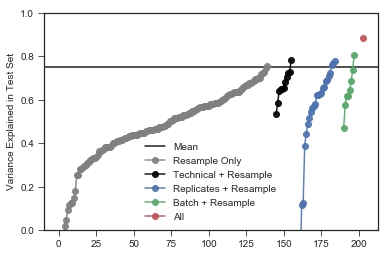

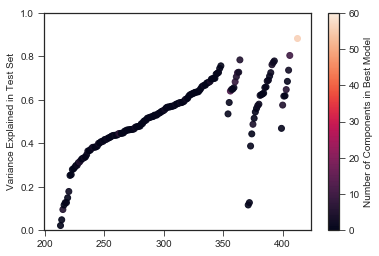

In [45]:
train_names = ['Resample Only','Technical + Resample','Replicates + Resample','Batch + Resample','All']
train_colors = ['gray','black','b','g','r']
prediction_sets = [resample_predictions,technical_predictions,rep_predictions,batch_predictions,all_predictions]

predictions = []
model_ranks = []

for s in prediction_sets:
    a = np.asarray(list(s.values()))
    a = a[a[:,0].argsort()]
    predictions.append(list(a[:,0]))
    model_ranks.append(list(a[:,1]))


plt.figure()

running_index = 0
plt.axhline(mean_fits,color='k',label='Mean')
for p,p_set in enumerate(predictions):
    
    plt.plot(range(running_index,running_index+len(p_set)),p_set,'o-',color=train_colors[p],alpha=0.9,label=train_names[p])
#     plt.axvline(running_index,linestyle='--',color='gray')
    running_index += len(p_set) + 5

plt.legend()
plt.ylabel('Variance Explained in Test Set')
plt.ylim(0,1)
plt.savefig('layered_predictions_ranks.pdf',bbox_inches='tight')


plt.figure()
# cmaps = ['Greys','Greys','Blues','Greens','Reds']

for p,p_set in enumerate(predictions):
#     cmap = plt.cm.get_cmap(cmaps[p])
    sc = plt.scatter(range(running_index,running_index+len(p_set)),p_set,c=model_ranks[p],vmin=0,vmax=60,alpha=0.9)
    print(max(model_ranks[p]))
#     sc = plt.scatter(range(running_index,running_index+len(p_set)),p_set,c=model_ranks[p],vmin=0,vmax=60,alpha=0.9,cmap=cmap)
    running_index += len(p_set) + 5
plt.colorbar(sc,label='Number of Components in Best Model')

# plt.legend()
plt.ylabel('Variance Explained in Test Set')
plt.ylim(0,1)
plt.savefig('layered_predictions_n_components_ranks.pdf',bbox_inches='tight')

In [46]:
fitness

array([[217., 216., 216., ..., 218., 219., 218.],
       [144., 110., 136., ...,   4.,  11.,  19.],
       [194., 195., 196., ..., 201., 201., 203.],
       ...,
       [155., 153., 145., ..., 171., 170., 170.],
       [ 12.,  13.,  13., ..., 104.,  89.,  45.],
       [ 45.,  16.,  30., ...,  40.,  46., 103.]])

In [171]:
train_names = ['Resample Only','Technical + Resample','Replicates + Resample','Batch + Resample','All']
train_colors = ['gray','black','b','g','r']
predictions = [list(sorted(resample_predictions.values())),
               list(sorted(technical_predictions.values())),
               list(sorted(rep_predictions.values())),
               list(sorted(batch_predictions.values())),
              list(sorted(all_predictions.values()))]

running_index = 0
plt.axhline(mean_fits,color='k',label='Mean')
for p,p_set in enumerate(predictions):
    
    plt.plot(range(running_index,running_index+len(p_set)),p_set,'o-',color=train_colors[p],alpha=0.9,label=train_names[p])
#     if p+1 == len(predictions):
#         plt.plot(range(running_index,running_index+len(p_set)),p_set,'o-',color='r')
#     else:
#         plt.plot(range(running_index,running_index+len(p_set)),p_set,'o-',color='b')
#         plt.axvline(running_index,linestyle='--',color='gray')
    running_index += len(p_set) + 5

plt.legend()
plt.ylabel('Variance Explained in Test Set')
plt.ylim(0,1)
plt.savefig('layered_predictions.pdf',bbox_inches='tight')

[0.7895709042642823,
 0.8636297705227355,
 0.8752486183568116,
 0.8767219518873699,
 0.8844291580286193,
 0.887547548921681,
 0.8867924674818408,
 0.8949735807591437,
 0.89477838349011,
 0.9083844377637014,
 0.9081909702593012,
 0.9088823600965656,
 0.9137176083310229,
 0.9138431511706225,
 0.9178717610211696,
 0.9175351860743388,
 0.9174950579808525,
 0.9185242407150607,
 0.9188200717294767,
 0.9188398520387876,
 0.9198568819676722,
 0.9205846710380757,
 0.9198993264212678,
 0.9204335768593717,
 0.9214615863293113,
 0.921131985544795,
 0.9202793406170904,
 0.9196778774252046,
 0.9197150731933101,
 0.9180238091515939,
 0.9181941449953233,
 0.9181386841889891,
 0.9175734795547441,
 0.916939028211169,
 0.9180223617562271,
 0.9170289605824552,
 0.9166142212486763,
 0.9167238422902835,
 0.9157404253218514,
 0.9156138244592665,
 0.9155168316303053,
 0.9151388564639598,
 0.9150418515728834,
 0.9134306862706725,
 0.9137129789219381,
 0.913127133151023,
 0.9126546693877134,
 0.9135704018686492

In [136]:
technical_predictions.keys()

dict_keys(['A_1', 'B_0', 'B_1', 'B_2', 'B_3', 'C_1', 'C_2', 'C_3', 'D_1', 'D_2', 'D_3'])

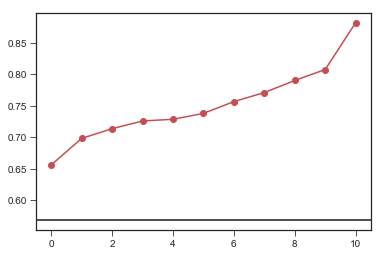

In [126]:
plt.plot(sorted(technical_predictions.values()),'o-',color='r')
plt.axhline(mean_fits,color='k')

In [30]:
import scipy

scipy.stats.rankdata(fitness[:,i])

array([219., 123., 207., 176., 206., 222., 218., 216., 161., 210., 170.,
       191., 155.,  45.,  89., 119., 208., 217.,  12.,  55., 156., 160.,
       188.,  92.,  75.,  67.,  66., 152.,   8., 195., 150., 209., 201.,
       211., 194., 149., 153., 138., 214., 182., 184.,  58., 166., 163.,
        25.,  74., 223.,   6.,  29., 124., 198., 159.,  21.,  20., 177.,
       158., 190., 213., 171.,  15., 178.,  86., 141., 186., 199., 168.,
       183., 143.,  54.,  68.,  97., 212., 203., 116., 193., 196.,  63.,
        32., 185., 192., 146.,  49., 175., 189.,  35., 180.,  72.,  28.,
       220., 224., 117., 121., 215., 167.,  53., 202.,  51.,  64.,   3.,
       174., 179., 118., 148.,  44., 100., 169., 197., 172.,  78., 162.,
       147.,   5.,  57.,  48.,  23.,  87.,   1.,  71., 221.,  46.,  37.,
       135.,  47., 122., 139.,  17., 157., 130.,  42.,  31., 181.,  13.,
        27., 140., 134., 131.,  83.,  81., 187., 109.,  39., 112.,  85.,
       205.,  30.,  34., 173.,  40.,  26.,  70.,  6

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


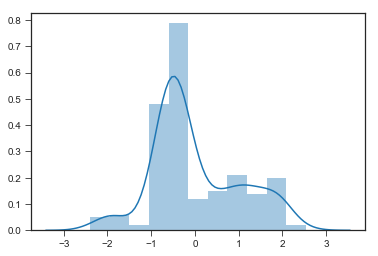

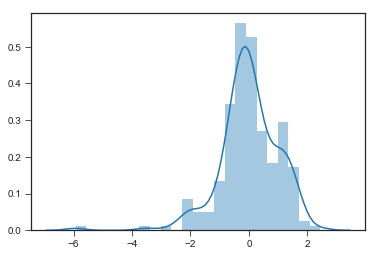

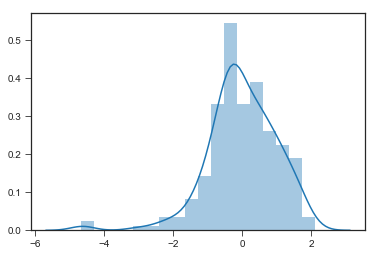

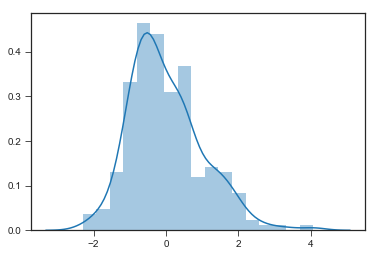

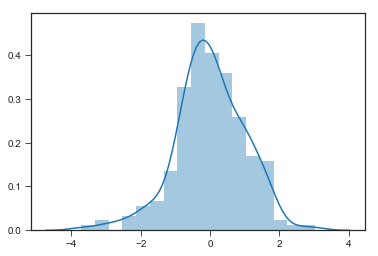

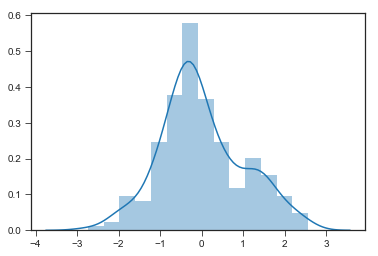

In [26]:


for i in [0,400,800,1200,1600,2000]:
    plt.figure()
    sns.distplot(fitness[:,i])

In [9]:
tech_cols = [col for col in fitness_cols if 'DE' in col and 'resample' in col]

tech_single_t_train_sets = {}
for rep in ['A','B','C','D']:
    for t in range(4):
        this_rep_t = [col for col in tech_cols if f'{rep}.' in col and f'.{t}-' in col]
        
        tech_single_t_train_sets[f'{rep}_{t}'] = this_rep_t

tech_single_rep_train_sets = {}
for rep in ['A','B','C','D']:
    this_rep = [col for col in tech_cols if f'{rep}.' in col]
        
    tech_single_rep_train_sets[f'{rep}'] = this_rep
    
tech_rep_train_sets = {**tech_single_t_train_sets, **tech_single_rep_train_sets}

tech_rep_train_sets['AllTechReps'] = [rep for reps in tech_rep_train_sets.values() for rep in reps]
